# Load Modules

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
import seaborn as sns
from tqdm import tqdm
from umap import UMAP

import scripts.NN as nn
import scripts.io as io

# Autoencoder

## Generate Test Dataset

<AxesSubplot:>

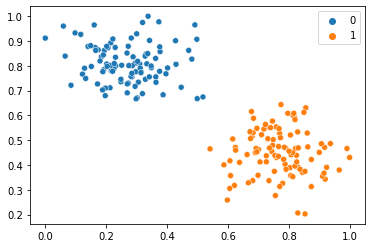

In [2]:
np.random.seed(42)

# create dataset
X, labels = make_blobs(n_samples = 200, n_features=8, centers=2)

# normalize X
X = io.norm(X)

# plot a features 0 and 1 against each other to show separation
sns.scatterplot(
    x = X[:,0], y = X[:, 1], hue = labels
)

## Initialize Autoencoder

In [3]:
np.random.seed(42)

net = nn.NeuralNetwork(
    layers = [
        (8, None),
        (4, nn.Sigmoid),
        (8, nn.Sigmoid)
    ],
    learning_rate=0.8
)

Loss = nn.MSE()

## Train Autoencoder

In [4]:
net.fit(X, X, Loss, n_epochs=100)

# Classification of Binding Sites

## Prepare Data

I've decided to use a OneHotEncoding (OHE) representation of the nucleotide sequences. The kmer sizes are fixed at size 17 and the OHE matrix (17x4) is flattened into a 1D vector of size 68. The representation does not take into consideration the positional weight matrix of a given KMER, and could be sensitive to random fluctuations introduced by sequencing errors - but it is a fast, clean, and ordinal free representation of the underlying sequence data. 

In [5]:
negative_fa = "data/yeast-upstream-1k-negative.fa"
positives_txt = "data/rap1-lieb-positives.txt"
test_txt = "data/rap1-lieb-test.txt"

# initialize fasta reader class
fa = io.FastaReader(negative_fa)

# initialize kmer generation class
km = io.Kmerize()

### Read in Positives

In [6]:
# read in txt file of kmers
kms = set([line.strip() for line in open(positives_txt, "r")])

# convert kmers to OHE
ohe_positives = np.array([
    io.OneHotEncoding(k, lookup=km.lookup, flatten=True) for k in kms
])

# show shape of matrix
ohe_positives.shape

(137, 68)

### Read in Negatives

In [7]:
# read in negative kmers as OHE if they aren't found in positives kmer set
ohe_negatives = np.array([
    io.OneHotEncoding(k, lookup=km.lookup, flatten=True) for k in km.process(fa) if k not in kms
])

# show shape of matrix
ohe_negatives.shape

(3110605, 68)

### Merge Data

In [8]:
np.random.seed(42)

# take random subset of negatives at 2X representation of positives
subset_negatives = io.SubsetData(ohe_negatives, n=ohe_positives.shape[0]*2)

# build labels of positives and negatives (1/0 respectively)
labels = np.concatenate([
    np.ones(ohe_positives.shape[0]),
    np.zeros(subset_negatives.shape[0])
])

# convert labels to OHE representation
ohe_labels = io.OneHotEncoding(labels)

# concatenate OHE positives and OHE Subset Negatives
ohe_data = np.concatenate([
    ohe_positives, subset_negatives
])

# Show shape of merged matrix
print("Matrix Shape: ", ohe_data.shape)

Matrix Shape:  (411, 68)


### Training Regime

I'm overrepresenting the negatives examples at a ratio of 2:1 wrt to positives. I've removed all negative kmers that are represented in the positive example set. I will be splitting the merged dataset at fraction 0.8 for training and using 0.2 of the dataset as validation. The network will be trained for 300 epochs with a softmax cross entropy loss function on the training set and then performance will be measured on the validation set. 

### Split Training and Test Set

In [9]:
train_x, test_x, train_y, test_y = io.TrainTestSplit(ohe_data, ohe_labels, train_size=0.8)

## Initialize Network

In [10]:
np.random.seed(42)
net = nn.NeuralNetwork(
    layers = [
        (68, None),
        (20, nn.Sigmoid),
        (2, nn.Free)
    ],
    learning_rate=0.8
)
Loss = nn.CE()

## Train Network

In [11]:
net.fit(train_x, train_y, Loss, n_epochs=100)

## Predict Validation

In [12]:
# feed forward validation set and find predictions
predictions = net.predict(test_x).argmax(axis=1)

# convert truth ohe to labels
truth = np.argmax(test_y, axis=1)

## Visualize Predictions

In [13]:
um = UMAP(metric = 'cosine')
scatter = um.fit_transform(test_x)

### Visualize Truth

<AxesSubplot:>

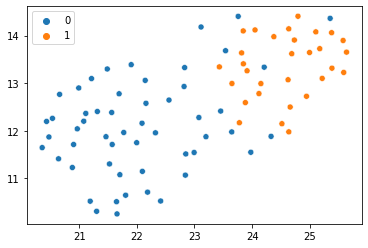

In [14]:
sns.scatterplot(
    x = scatter[:,0], y = scatter[:, 1], 
    hue = np.argmax(test_y, axis=1)
)

### Visualize Predictions

<AxesSubplot:>

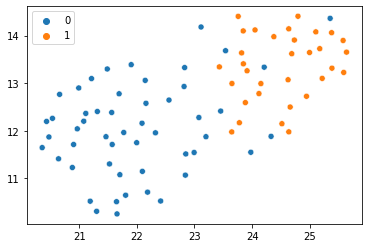

In [15]:
sns.scatterplot(
    x = scatter[:,0], y = scatter[:, 1], 
    hue = predictions
)

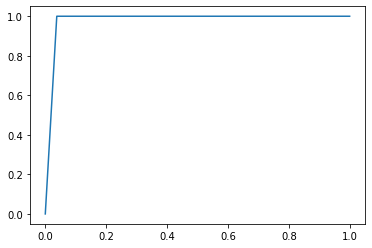

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresh = roc_curve(truth, predictions)
auc = roc_auc_score(truth, predictions)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))

## Example Predictions

In [17]:
alphabet = np.array([i for i in km.lookup])


true_positives = test_x[(truth == predictions) & (truth == 1)]
true_negatives = test_x[(truth == predictions) & (truth == 0)]

tn = io.InverseOneHotEncoding(
    true_negatives[np.random.choice(true_negatives.shape[0])], 
    alphabet=alphabet
)

tp = io.InverseOneHotEncoding(
    true_positives[np.random.choice(true_positives.shape[0])], 
    alphabet=alphabet
)

print("True Negative Example : \n {}\n".format(tn))
print("True Positive Example : \n {}\n".format(tp))

True Negative Example : 
 CTTTTATAGAGCAAACG

True Positive Example : 
 ACACCCATGCATTATTG



## Discussion

My model architecture was actually very simple: 

There are 68 input nodes that are passed to 20 hidden nodes which are sigmoid activated and passed to 2 output nodes that are evaluated via softmax cross entropy loss. 

I decided to not use any convergence criteria and instead ran the model for a defined number of epochs (100). The error minimization worked really well, and by the end of training there was only a 0.016 mean CE loss across all observations in the training set. 

The validation set had 100% predictive rate.

# Cross Validation

## Implementation

In [18]:
num_k = 30

scores = np.zeros(num_k)
for k in tqdm(np.arange(num_k)):
    
    # take random subset of negatives at 2X representation of positives
    subset_negatives = io.SubsetData(ohe_negatives, n=ohe_positives.shape[0]*2)

    # build labels of positives and negatives (1/0 respectively)
    labels = np.concatenate([
        np.ones(ohe_positives.shape[0]),
        np.zeros(subset_negatives.shape[0])
    ])

    # convert labels to OHE representation
    ohe_labels = io.OneHotEncoding(labels)

    # concatenate OHE positives and OHE Subset Negatives
    ohe_data = np.concatenate([
        ohe_positives, subset_negatives
    ])
    
    # split into train and validation sets
    train_x, test_x, train_y, test_y = io.TrainTestSplit(ohe_data, ohe_labels, train_size=0.8)
    
    # spin up a new network
    net = nn.NeuralNetwork(
        layers = [
            (68, None),
            (20, nn.Sigmoid),
            (2, nn.Free)
        ],
        learning_rate=0.8
    )
    Loss = nn.CE()
    
    # fit new network
    net.fit(train_x, train_y, Loss, n_epochs=100, verbose=False)
    
    # feed forward validation set and find predictions
    predictions = net.predict(test_x).argmax(axis=1)

    # convert truth ohe to labels
    truth = np.argmax(test_y, axis=1)
    
    # calculate score of run
    scores[k] = np.mean(predictions == truth)

100%|██████████| 30/30 [02:12<00:00,  4.41s/it]


## Visualization of Scores

<AxesSubplot:ylabel='Count'>

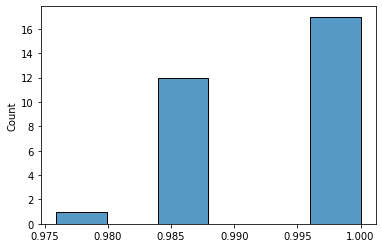

In [19]:
sns.histplot(scores)

## Discussion

K-Fold Validation is a good way of measuring model performance because it allows for random hold out sets. It's training a new model with different input splits, ideally removing the chance of memorization or lucky splits when evaluating a model. I decided to do a 30-k fold validation to see wwhat the distribution of scores I see is.

Each k-fold run takes a new random sample of negative examples at 2X representation from the positives, merges the positives and negatives, then randomly splits into train and validation sets at a 0.8 train/validation fraction. The scores are calculated as the mean of correct predictions. 

The Model performed very well under cross-validation, with the worst example still passing the 0.95% correct threshold. 

# Extension

## Minibatch Regularization

In [20]:
num_k = 30

scores = np.zeros(num_k)
for k in tqdm(np.arange(num_k)):
    
    # take random subset of negatives at 2X representation of positives
    subset_negatives = io.SubsetData(ohe_negatives, n=ohe_positives.shape[0]*2)

    # build labels of positives and negatives (1/0 respectively)
    labels = np.concatenate([
        np.ones(ohe_positives.shape[0]),
        np.zeros(subset_negatives.shape[0])
    ])

    # convert labels to OHE representation
    ohe_labels = io.OneHotEncoding(labels)

    # concatenate OHE positives and OHE Subset Negatives
    ohe_data = np.concatenate([
        ohe_positives, subset_negatives
    ])
    
    # split into train and validation sets
    train_x, test_x, train_y, test_y = io.TrainTestSplit(ohe_data, ohe_labels, train_size=0.8)
    
    # spin up a new network
    net = nn.NeuralNetwork(
        layers = [
            (68, None),
            (20, nn.Sigmoid),
            (2, nn.Free)
        ],
        learning_rate=0.8
    )
    Loss = nn.CE()
    
    # fit new network
    net.minibatch_fit(train_x, train_y, Loss, n_epochs=100, batch_size=30, verbose=False)
    
    # feed forward validation set and find predictions
    predictions = net.predict(test_x).argmax(axis=1)

    # convert truth ohe to labels
    truth = np.argmax(test_y, axis=1)
    
    # calculate score of run
    scores[k] = np.mean(predictions == truth)

100%|██████████| 30/30 [02:13<00:00,  4.44s/it]


### Visualization

<AxesSubplot:ylabel='Count'>

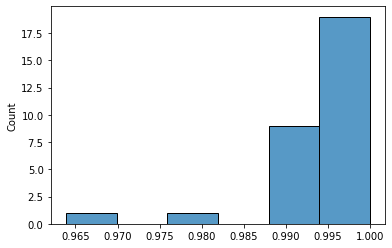

In [21]:
sns.histplot(scores)

### Discussion

I tried out a minibatch implementation here - so instead of updating all the weights at once at the end of the epoch I update them every b observations where b is the minibatch parameter. I measured performance via k-fold validation and the results are very similar to the original optimization method. I think this model could potentially work better by reducing the number of epochs - I have a feeling it is being overfitted, but I want to hold everything else constant when running the parameter search so I did not change the n_epochs

## The Minimal Model Approach

In [ ]:
num_k = 30

scores = np.zeros(num_k)
for k in tqdm(np.arange(num_k)):
    
    # take random subset of negatives at 2X representation of positives
    subset_negatives = io.SubsetData(ohe_negatives, n=ohe_positives.shape[0]*2)

    # build labels of positives and negatives (1/0 respectively)
    labels = np.concatenate([
        np.ones(ohe_positives.shape[0]),
        np.zeros(subset_negatives.shape[0])
    ])

    # convert labels to OHE representation
    ohe_labels = io.OneHotEncoding(labels)

    # concatenate OHE positives and OHE Subset Negatives
    ohe_data = np.concatenate([
        ohe_positives, subset_negatives
    ])
    
    # split into train and validation sets
    train_x, test_x, train_y, test_y = io.TrainTestSplit(ohe_data, ohe_labels, train_size=0.8)
    
    # spin up a new network
    net = nn.NeuralNetwork(
        layers = [
            (68, None),
            (2, nn.Free)
        ],
        learning_rate=0.3
    )
    Loss = nn.CE()
    
    # fit new network
    net.minibatch_fit(train_x, train_y, Loss, n_epochs=100, batch_size=30, verbose=False)
    
    # feed forward validation set and find predictions
    predictions = net.predict(test_x).argmax(axis=1)

    # convert truth ohe to labels
    truth = np.argmax(test_y, axis=1)
    
    # calculate score of run
    scores[k] = np.mean(predictions == truth)

 97%|█████████▋| 29/30 [01:01<00:02,  2.16s/it]

### Visualization

In [ ]:
sns.histplot(scores)

### Discussion

This is the bare minimum model approach where I actually removed all hidden layers. This is a fully connected network of input to output with softmax cross entropy loss. It surprisingly does really well! I trained it via minibatch updates and lowered the learning rate to 0.3 from 0.8. The k-fold validation results are promising and shows that perhaps additional hidden layers may be overkill for this problem. 

# Final Testing

In [ ]:
# read in txt file of kmers
kmers_test = set([line.strip() for line in open(test_txt, "r")])

# convert kmers to OHE
ohe_test = np.array([
    io.OneHotEncoding(k, lookup=km.lookup, flatten=True) for k in kmers_test
])

ohe_test.shape

In [ ]:
np.random.seed(42)

# take random subset of negatives at 2X representation of positives
subset_negatives = io.SubsetData(ohe_negatives, n=ohe_positives.shape[0]*2)

# build labels of positives and negatives (1/0 respectively)
labels = np.concatenate([
    np.ones(ohe_positives.shape[0]),
    np.zeros(subset_negatives.shape[0])
])

# convert labels to OHE representation
ohe_labels = io.OneHotEncoding(labels)

# concatenate OHE positives and OHE Subset Negatives
ohe_data = np.concatenate([
    ohe_positives, subset_negatives
])

# split into train and validation sets
train_x, test_x, train_y, test_y = io.TrainTestSplit(ohe_data, ohe_labels, train_size=0.8)

# spin up a new network
net = nn.NeuralNetwork(
    layers = [
        (68, None),
        (20, nn.Sigmoid),
        (2, nn.Free)
    ],
    learning_rate=0.3
)
Loss = nn.CE()

# fit new network
net.minibatch_fit(train_x, train_y, Loss, n_epochs=100, batch_size=30, verbose=False)

# feed forward validation set and find predictions
predictions = net.predict(ohe_test).argmax(axis=1)

In [ ]:
with open("data/rap1_predictions.tsv", "w+") as f:
    for idx, ohe in enumerate(ohe_test):
        seq = io.InverseOneHotEncoding(ohe, alphabet=alphabet)
        label = predictions[idx]
        
        f.write("{}\t{}\n".format(seq, label))

## Visualization of Prediction

In [ ]:
um = UMAP(metric='cosine', random_state=42)
scatter = um.fit_transform(ohe_test)

sns.scatterplot(
    x = scatter[:,0], y = scatter[:,1],
    hue = predictions
)